<a href="https://colab.research.google.com/github/iotparth/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/Neural\ Style\ Transfer

/content/drive/My Drive/Neural Style Transfer


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

In [ ]:
# Download the VGG19 pretrained model.
!python download_vgg_script.py

[==================================================]

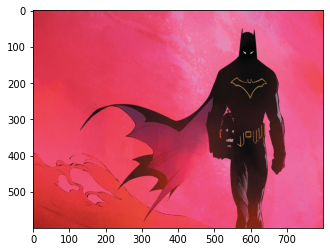

In [ ]:
content_image = imageio.imread('bat.jpeg')
imshow(content_image)

In [ ]:
# compute_content_cost

def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.shape

    new_shape = [int(m), int(n_H * n_W), int(n_C)]

    a_C_unrolled = tf.reshape(a_C, new_shape)
    a_G_unrolled = tf.reshape(a_G, new_shape)

    J_content = (.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(tf.pow(a_G_unrolled - a_C_unrolled, 2))

    return J_content

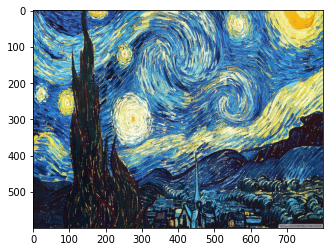

In [ ]:
style_image = imageio.imread("style.jpg")
imshow(style_image)

In [ ]:
# gram_matrix

def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [ ]:
# compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    factor = (.5 / (n_H * n_W * n_C)) ** 2
    J_style_layer = factor * tf.reduce_sum(tf.pow(GS - GG, 2))

    return J_style_layer

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [ ]:
# Style cost
def compute_style_cost(model, STYLE_LAYERS):

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [ ]:
# Total cost

def total_cost(J_content, J_style, alpha = 20, beta = 30):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [ ]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [ ]:
# Load content image
content_image = imageio.imread("bat.jpeg")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
content_image.shape

(1, 600, 800, 3)

In [ ]:
# Load style image
style_image = imageio.imread("style.jpg")
style_image = reshape_and_normalize_image(style_image)

In [ ]:
style_image.shape

(1, 600, 800, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


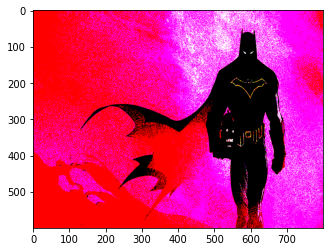

In [ ]:
# Fill noise in content image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [ ]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [ ]:

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

a_C = sess.run(out)

a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [ ]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
# Compute Total cost
J = total_cost(J_content, J_style, alpha = 20, beta = 30)

In [ ]:
# optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# train_step 
train_step = optimizer.minimize(J)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
def model_nn(sess, input_image, num_iterations=400):
    # Initialize global variables
    sess.run(tf.global_variables_initializer())

    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):

        # Run the session on the train_step to minimize the total cost
        somthing = sess.run(train_step)

        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # save current generated image in the "/output" directory
            save_image("output_1_" + str(i) + ".png", generated_image)

    # save last generated image
    save_image('output/generated_image.jpg', generated_image)

    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 19152509000.0
content cost = 10927.33
style cost = 638409660.0
Iteration 20 :
total cost = 3870655000.0
content cost = 25450.65
style cost = 129004860.0
Iteration 40 :
total cost = 1917283800.0
content cost = 28251.145
style cost = 63890628.0
Iteration 60 :
total cost = 1195788200.0
content cost = 29882.006
style cost = 39839684.0
Iteration 80 :
total cost = 871112000.0
content cost = 30638.67
style cost = 29016640.0
Iteration 100 :
total cost = 687069400.0
content cost = 31102.213
style cost = 22881578.0
Iteration 120 :
total cost = 562692700.0
content cost = 31428.336
style cost = 18735470.0
Iteration 140 :
total cost = 469946500.0
content cost = 31712.758
style cost = 15643742.0
Iteration 160 :
total cost = 396944860.0
content cost = 31974.924
style cost = 13210179.0
Iteration 180 :
total cost = 337300060.0
content cost = 32230.215
style cost = 11221849.0
Iteration 200 :
total cost = 287761820.0
content cost = 32478.613
style cost = 9570408.0
Iteration 220

array([[[[  75.528694 ,   52.14547  ,   24.516018 ],
         [  -8.424734 ,  -52.91135  ,  -35.86873  ],
         [   0.6254497,  -36.183838 ,  -48.019238 ],
         ...,
         [ 105.80559  ,   30.398607 ,   38.362442 ],
         [  72.54349  ,  -66.22397  ,  -11.209665 ],
         [  -5.2543826, -169.10806  ,    0.8403802]],

        [[  23.6864   ,  -12.913969 ,   23.213223 ],
         [ -16.697636 ,  -31.1772   ,  -17.507486 ],
         [  50.28979  ,   32.359226 ,   25.025743 ],
         ...,
         [ 129.67159  ,  102.27653  ,   46.015835 ],
         [  35.202877 ,  -58.16764  ,  -46.252316 ],
         [  13.865612 ,  -86.35873  ,  -59.20253  ]],

        [[ -70.87423  ,  -76.69629  ,  -26.505543 ],
         [-139.44624  ,  -75.731674 ,  -46.479683 ],
         [  20.974752 ,   43.55976  ,   51.148365 ],
         ...,
         [ 113.01186  ,   94.12643  ,   40.215927 ],
         [ 121.69242  ,  212.80385  ,   81.71876  ],
         [ -12.939367 ,  -67.795876 ,  -65.519966 ]],

Generated Image : 


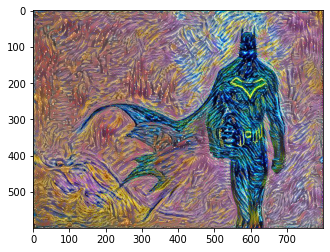

In [ ]:
print("Generated Image : ")
generated_image = imageio.imread("output/generated_image.jpg")
imshow(generated_image)
